<a href="https://colab.research.google.com/github/19ankita/Missing-spatial-temporal-multimodal-traffic-data-imputation-and-prediction/blob/main/FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas shapely pandas pyarrow

In [31]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [3]:
# Read the Parquet file
node_df = pd.read_parquet("road_graph_nodes.parquet")

In [7]:
# Convert the node DataFrame to a GeoDataFrame with same CRS as buildings
node_gdf = gpd.GeoDataFrame(
    node_df,
    geometry=[Point(xy) for xy in zip(node_df.x, node_df.y)],
    crs="EPSG:4326"
)

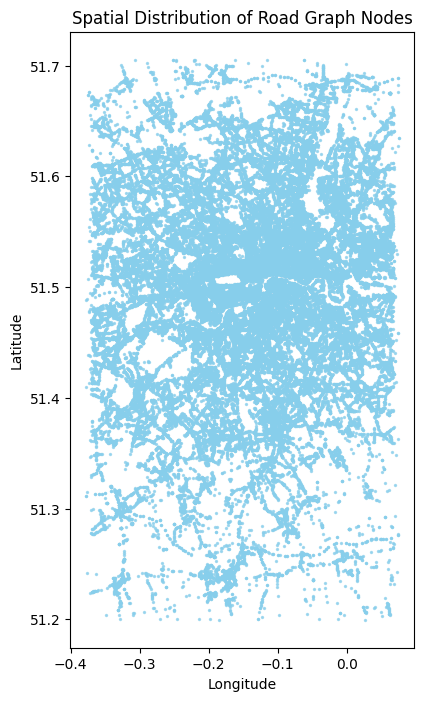

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot nodes on a map
fig, ax = plt.subplots(figsize=(10, 8))
node_gdf.plot(ax=ax, markersize=2, color='skyblue', alpha=0.7)
plt.title("Spatial Distribution of Road Graph Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig('graph_nodes.png')

In [11]:
node_gdf = node_gdf.to_crs("EPSG:32630")

In [12]:
building_gdf = gpd.read_file("gis_osm_buildings_a_free_1.shp")

In [13]:
building_gdf = building_gdf.to_crs("EPSG:32630")

In [14]:
# Print CRS values side by side
print(f"{'Dataset':<15} {'CRS':<30}")
print("=" * 50)
print(f"{'Node_GDF':<15} {str(node_gdf.crs):<30}")
print(f"{'Building_GDF':<15} {str(building_gdf.crs):<30}")

Dataset         CRS                           
Node_GDF        EPSG:32630                    
Building_GDF    EPSG:32630                    


In [15]:
building_gdf['building_area'] = building_gdf.area

In [16]:
# Extract unique building types
unique_types = building_gdf['type'].unique()

# Set number of columns for display
num_columns = 5

# Print in a structured format
for i, item in enumerate(unique_types, 1):
    print(f"{str(item):<25}", end="\t")  # Adjust width as needed
    if i % num_columns == 0:
        print()  # New line after every 'num_columns' items

# Ensure the last row is printed properly
print()

block                    	None                     	store                    	apartments               	warehouse                	
church                   	commercial               	supermarket              	office                   	train_station            	
stadium                  	retail                   	shop                     	school                   	hall                     	
depot                    	detached                 	hangar                   	cinema                   	parking                  	
government               	greenhouse               	laboratory               	university               	orangery                 	
pagoda                   	residential              	stable                   	hospital                 	industrial               	
pavilion                 	pier                     	transportation           	place_of_worship         	factory                  	
ship                     	tower                    	sports_centre            	terra

In [17]:
# Apply a buffer of 50 meters to each node to define the search area
node_gdf['buffered'] = node_gdf.buffer(50)

# Use the buffered geometry for spatial join
# It's important to use the buffered geometry column for the spatial operation
node_gdf.set_geometry('buffered', inplace=True)

# Perform the spatial join to find buildings within 50 meters of each node
# Changing how="left" to ensure all nodes are kept
joined_gdf_utm = gpd.sjoin(node_gdf, building_gdf, how="left", predicate="intersects")

#Reset geometry to original points for any further operations or plotting
node_gdf.set_geometry('geometry', inplace=True)

In [18]:
joined_gdf_utm = joined_gdf_utm.drop(['index_right', 'osm_id', 'code',	'fclass', 'name'], axis=1)

In [19]:
# Fill NaN values in 'building_area' with zero
joined_gdf_utm['building_area'] = joined_gdf_utm['building_area'].fillna(0)

In [20]:
joined_gdf_utm['type'] = joined_gdf_utm['type'].fillna(0)

In [21]:
# Group by 'node_id' and aggregate
aggregated_df = joined_gdf_utm.groupby('node_id').agg({
    'counter_info': 'first',
    'num_assigned': 'first',
    'x': 'first',
    'y': 'first',
    'geometry': 'first',
    'buffered': 'first',
    'type': lambda x: list(x),
    'building_area': lambda x: list(x)
}).reset_index()

In [22]:
# Convert the result back to a GeoDataFrame if necessary
aggregated_gdf = gpd.GeoDataFrame(aggregated_df, geometry='geometry')

In [23]:
# Calculate building density (number of buildings per unit area)
# Building density in this context is defined as the number of buildings per unit area (e.g., buildings per square meter).
aggregated_gdf['building_density'] = aggregated_gdf['building_area'].apply(len) / aggregated_gdf['buffered'].area

In [24]:
# Normalize the building density
min_density = aggregated_gdf['building_density'].min()
max_density = aggregated_gdf['building_density'].max()
aggregated_gdf['building_density'] = (aggregated_gdf['building_density'] - min_density) / (max_density - min_density)

In [25]:
# Calculate the diversity of building types
aggregated_gdf['building_type_diversity'] = aggregated_gdf['type'].apply(lambda types: len(set(types)))

In [26]:
# Define the array of building types
building_types = ['apartments', 'commercial', 'supermarket', 'office', 'train_station', 'stadium',
                  'school', 'cinema', 'parking', 'government', 'university',  'residential',
                  'hospital', 'industrial', 'factory',  'sports_centre', 'hotel', 'flats', 'house',
                  'college',  'shopping_centre', 'theatre', 'central_office', 'dormitory',
                  'community_centre', 'fire_station', 'kindergarten', 'museum', 'mall', 'school_hostel',  'pub', 'public_building',
                  'university', 'restaurant', 'bus_station', 'car_park']

# Create new columns for each building type
for building_type in building_types:
    col_name = f'has_{building_type}'
    aggregated_gdf[col_name] = aggregated_gdf['type'].apply(lambda x: 1 if building_type in x else 0)

In [27]:
# Define function to determine location type
def determine_location_type(row):
    if row['has_residential'] and row['has_commercial']:
        return 'Mixed'
    elif row['has_residential']:
        return 'Residential'
    elif row['has_commercial']:
        return 'Commercial'
    elif row['has_school'] or row['has_university']:
        return 'Educational'
    elif row['has_hospital']:
        return 'Healthcare'
    elif row['has_industrial'] or row['has_factory']:
        return 'Industrial'
    else:
        return 'Other'

In [28]:
# Apply function to create new column 'location_type'
aggregated_gdf['location_type'] = aggregated_gdf.apply(determine_location_type, axis=1)


In [29]:
aggregated_gdf["type"] = aggregated_gdf["type"].astype(str)
aggregated_gdf.to_parquet("road_graph_nodes_FE.parquet", engine="pyarrow")

Boxplot: Building Area Distribution by Location Type

<ipython-input-32-378c0aeb4fa1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


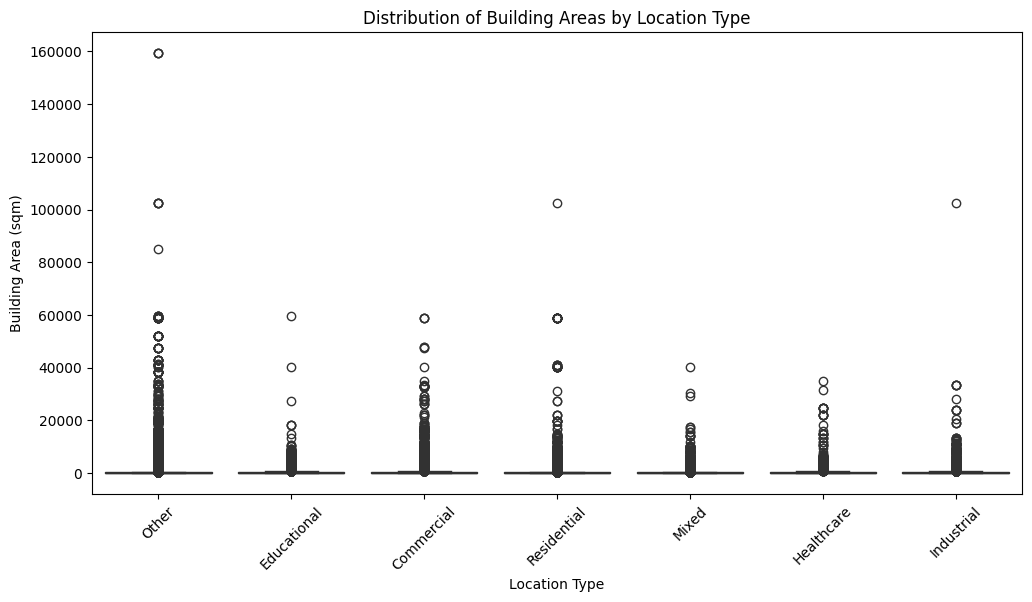

In [32]:
# Explode the building_area lists into individual rows
exploded_df = aggregated_gdf.explode('building_area').reset_index(drop=True)
exploded_df['building_area'] = exploded_df['building_area'].astype(float)

# Filter out nodes with no buildings (optional)
filtered_df = exploded_df[exploded_df['building_area'] > 0]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='location_type',
    y='building_area',
    data=filtered_df,
    palette='viridis'
)
plt.title('Distribution of Building Areas by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Building Area (sqm)')
plt.xticks(rotation=45)
plt.show()

Bar Chart: Average Building Density by Location Type

<ipython-input-34-0529dcff2d07>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


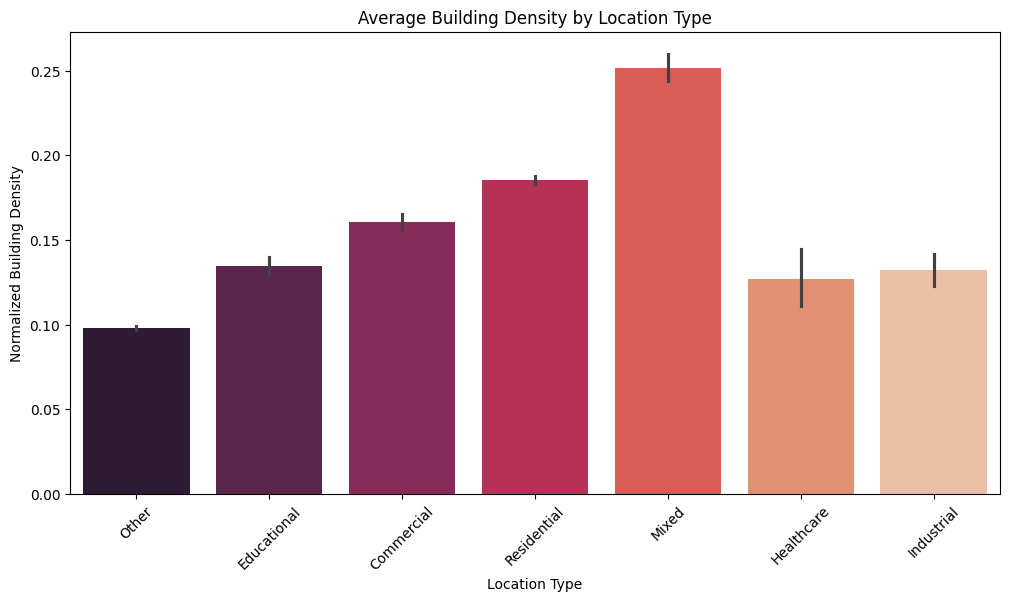

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='location_type',
    y='building_density',
    data=aggregated_gdf,
    estimator='mean',
    palette='rocket'
)
plt.title('Average Building Density by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Normalized Building Density')
plt.xticks(rotation=45)
plt.show()
plt.savefig("Average Building Density by Location Type.png")

Building Type Diversity

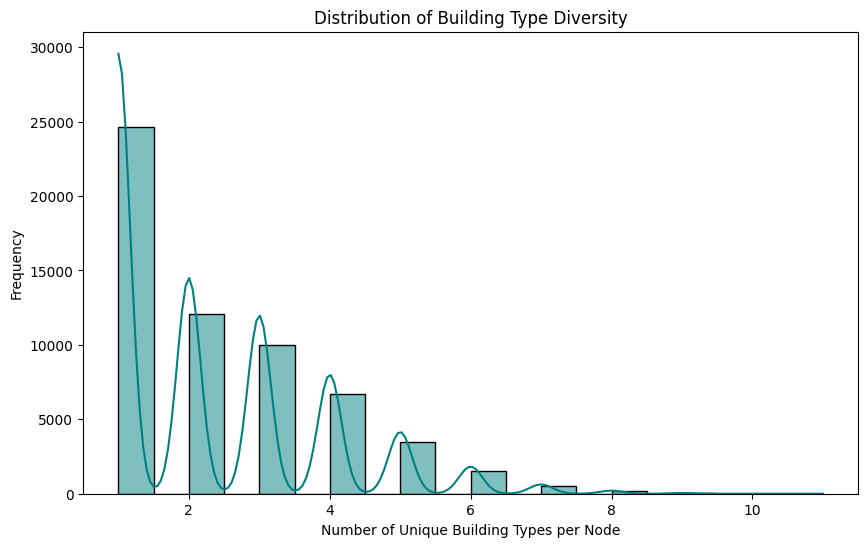

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(
    aggregated_gdf['building_type_diversity'],
    bins=20,
    kde=True,
    color='teal'
)
plt.title('Distribution of Building Type Diversity')
plt.xlabel('Number of Unique Building Types per Node')
plt.ylabel('Frequency')
plt.show()

Location Type Distribution

<ipython-input-36-aa3e59a271db>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


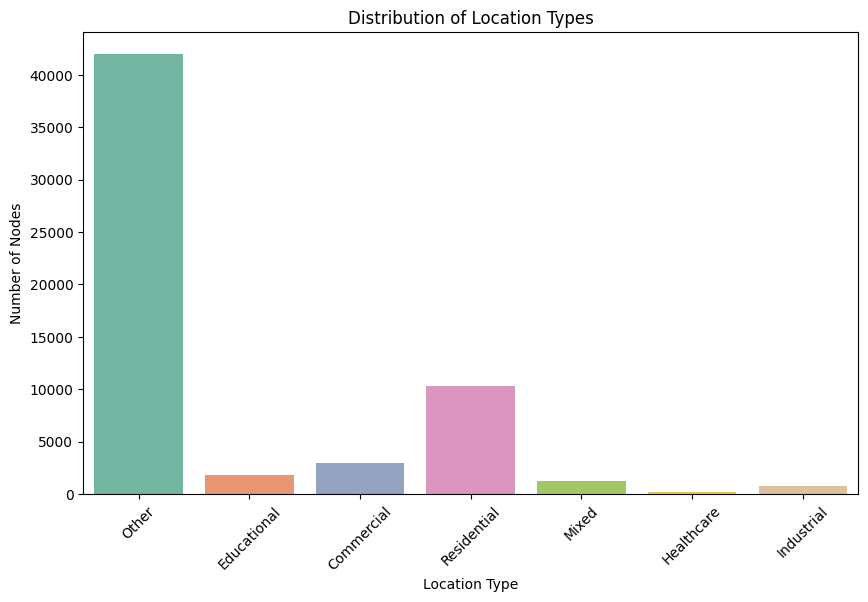

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x='location_type',
    data=aggregated_gdf,
    palette='Set2'
)
plt.title('Distribution of Location Types')
plt.xlabel('Location Type')
plt.ylabel('Number of Nodes')
plt.xticks(rotation=45)
plt.show()

Building Density vs. Diversity

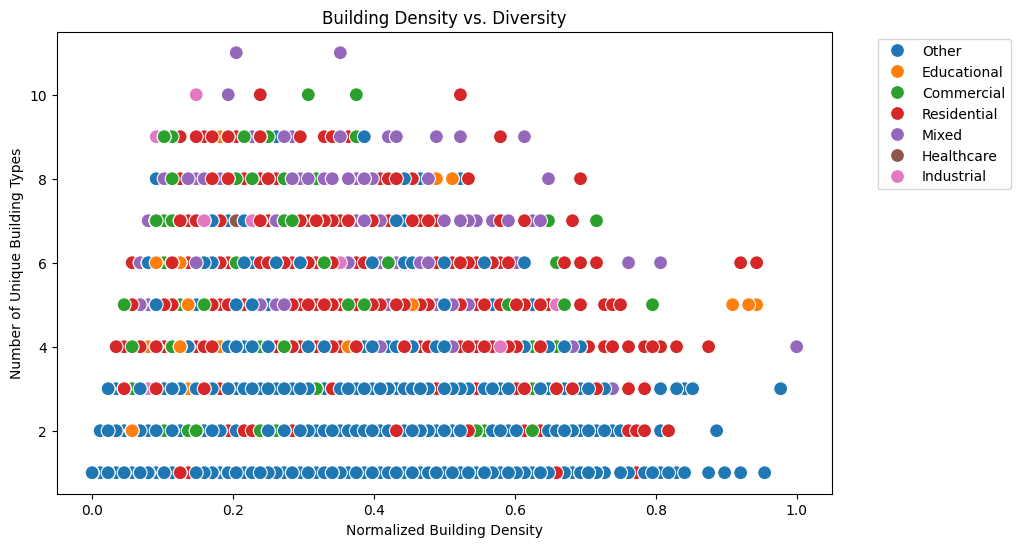

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='building_density',
    y='building_type_diversity',
    hue='location_type',
    data=aggregated_gdf,
    palette='tab10',
    s=100
)
plt.title('Building Density vs. Diversity')
plt.xlabel('Normalized Building Density')
plt.ylabel('Number of Unique Building Types')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()